# Setup

In [1]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import imageio
import shutil

# --- Define Local File Paths ---

# Path to your WHO AQI CSV file
csv_file_path = 'who_aqi.csv'

# Path to your UNZIPPED Natural Earth .shp file
world_map_shp_path = './NE_countries/ne_110m_admin_0_countries.shp'

# Directory to save temporary image frames for the GIF
temp_frames_dir = './temp_global_aqi_frames/'

# Output path for the final GIF animation
output_gif_path = './global_pm10_aqi_animation.gif'

# --- Create necessary directories ---
os.makedirs(temp_frames_dir, exist_ok=True)
print(f"Temporary directory for frames created: {temp_frames_dir}")

Temporary directory for frames created: ./temp_global_aqi_frames/


In [18]:
df = pd.read_csv(csv_file_path)
print("CSV file loaded successfully as a pandas DataFrame!")

# --- Data Cleaning and Preparation for GeoDataFrame ---
pollutant_column = 'pm10_concentration'
legend_label = "PM10 Concentration (µg/m³)" # Corrected from PM1.0

if 'latitude' in df.columns and 'longitude' in df.columns and pollutant_column in df.columns:
    print(f"Preparing data for GeoDataFrame conversion using '{pollutant_column}'...")

    initial_rows = len(df)
    df_cleaned = df.dropna(subset=['latitude', 'longitude', pollutant_column]).copy()
    rows_after_drop = len(df_cleaned)
    print(f"Dropped {initial_rows - rows_after_drop} rows with missing essential data.")

    # Ensure latitude, longitude, and pollutant_column are numeric.
    df_cleaned['latitude'] = pd.to_numeric(df_cleaned['latitude'], errors='coerce')
    df_cleaned['longitude'] = pd.to_numeric(df_cleaned['longitude'], errors='coerce')
    df_cleaned[pollutant_column] = pd.to_numeric(df_cleaned[pollutant_column], errors='coerce')

    # Drop any rows that became NaN after coercion
    df_cleaned.dropna(subset=['latitude', 'longitude', pollutant_column], inplace=True)
    print(f"Remaining rows after ensuring numeric types: {len(df_cleaned)}")
    df_cleaned['year'] = df_cleaned['year'].astype(int)

    # Convert to GeoDataFrame
    print("Converting to GeoDataFrame...")
    gdf = gpd.GeoDataFrame(
        df_cleaned,
        geometry=gpd.points_from_xy(df_cleaned.longitude, df_cleaned.latitude),
        crs="EPSG:4326" # Standard for lat/lon coordinates
    )
    print("GeoDataFrame created successfully!")
    print(f"GeoDataFrame Head:\n{gdf.head()}")
    print(f"GeoDataFrame CRS: {gdf.crs}")

CSV file loaded successfully as a pandas DataFrame!
Preparing data for GeoDataFrame conversion using 'pm10_concentration'...
Dropped 11716 rows with missing essential data.
Remaining rows after ensuring numeric types: 28672
Converting to GeoDataFrame...
GeoDataFrame created successfully!
GeoDataFrame Head:
  who_region iso3 country_name          city  year  \
0      4_Eur  ESP        Spain  A Coruna/ESP  2013   
1      4_Eur  ESP        Spain  A Coruna/ESP  2014   
2      4_Eur  ESP        Spain  A Coruna/ESP  2015   
3      4_Eur  ESP        Spain  A Coruna/ESP  2016   
4      4_Eur  ESP        Spain  A Coruna/ESP  2017   

                                             version  pm10_concentration  \
0  V4.0 (2018), V4.0 (2018), V4.0 (2018), V4.0 (2...              23.238   
1           V6.0  (2023), V6.0  (2023), V6.0  (2023)              27.476   
2  V6.0  (2023), V6.0  (2023), V6.0  (2023), V6.0...              25.515   
3  V6.0  (2023), V6.0  (2023), V6.0  (2023), V6.0...           

In [19]:
world = gpd.read_file(world_map_shp_path)
print("World map data loaded successfully!")
print(f"World map CRS: {world.crs}")

World map data loaded successfully!
World map CRS: EPSG:4326


In [20]:
gdf['year']

0        2013
1        2014
2        2015
3        2016
4        2017
         ... 
40091    2015
40092    2016
40093    2017
40094    2018
40095    2019
Name: year, Length: 28672, dtype: int64

Years available in data: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


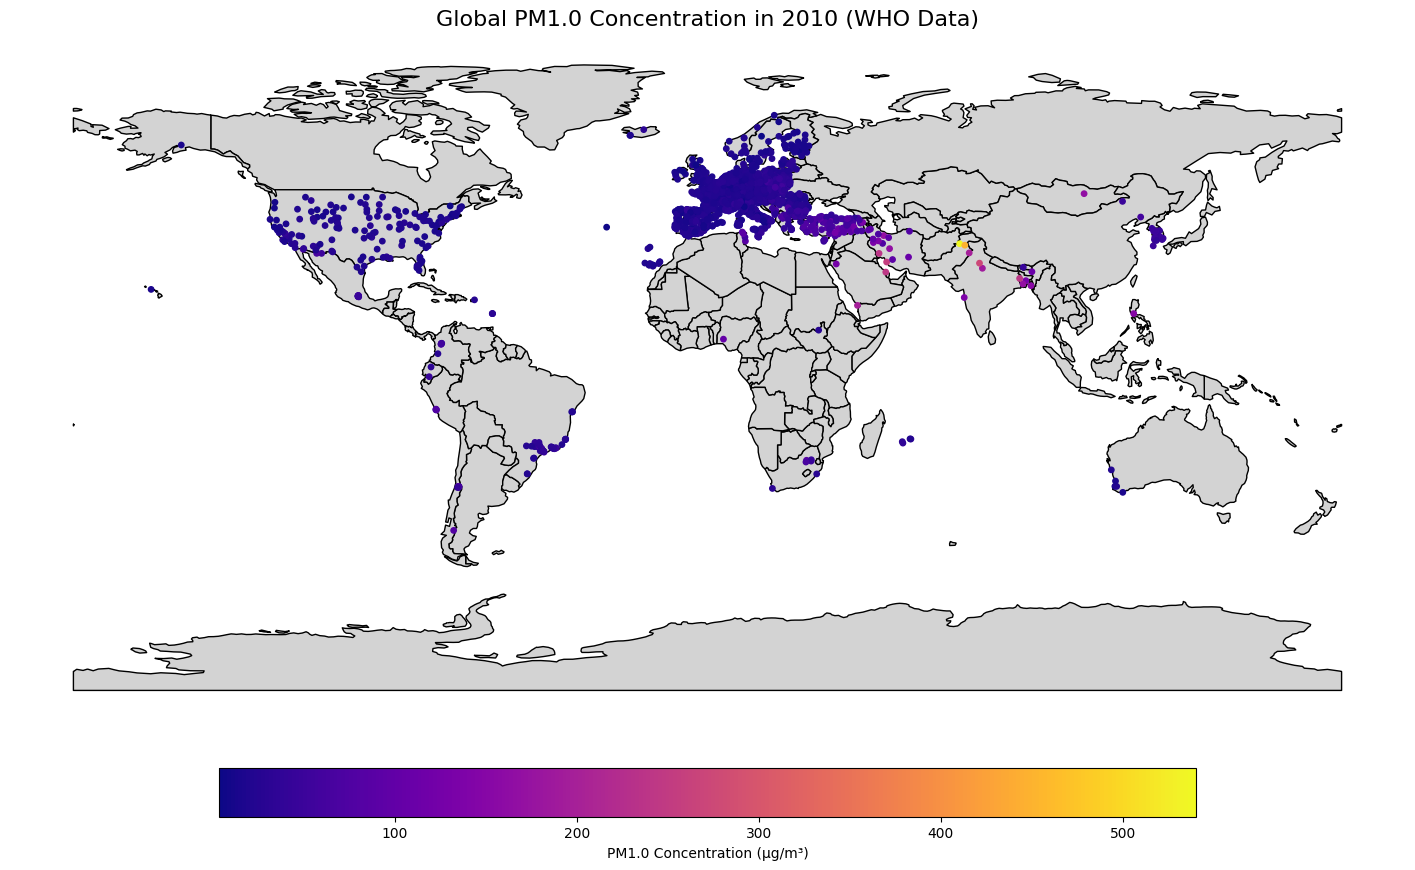

Saved frame for year 2010


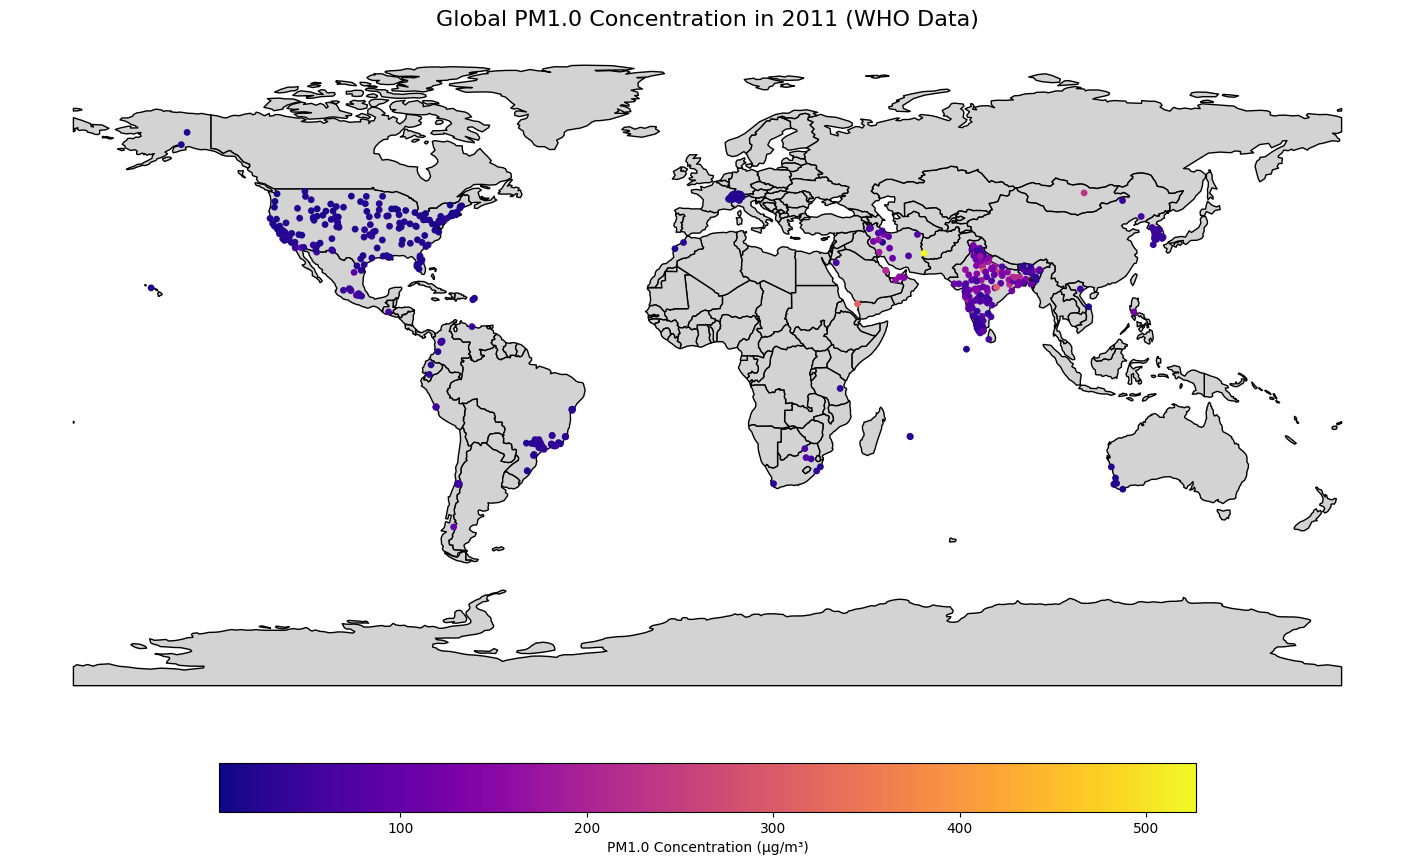

Saved frame for year 2011


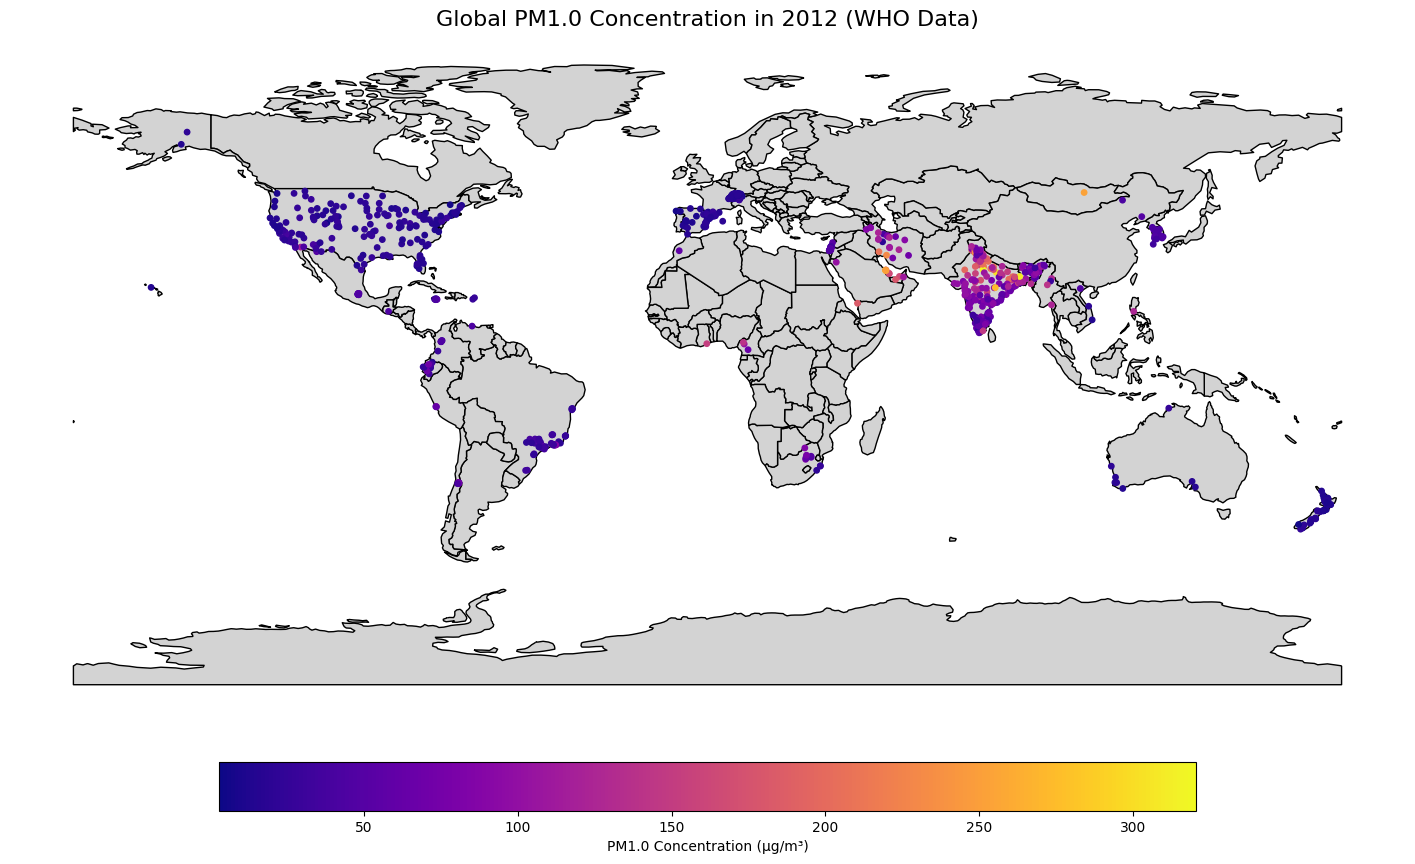

Saved frame for year 2012


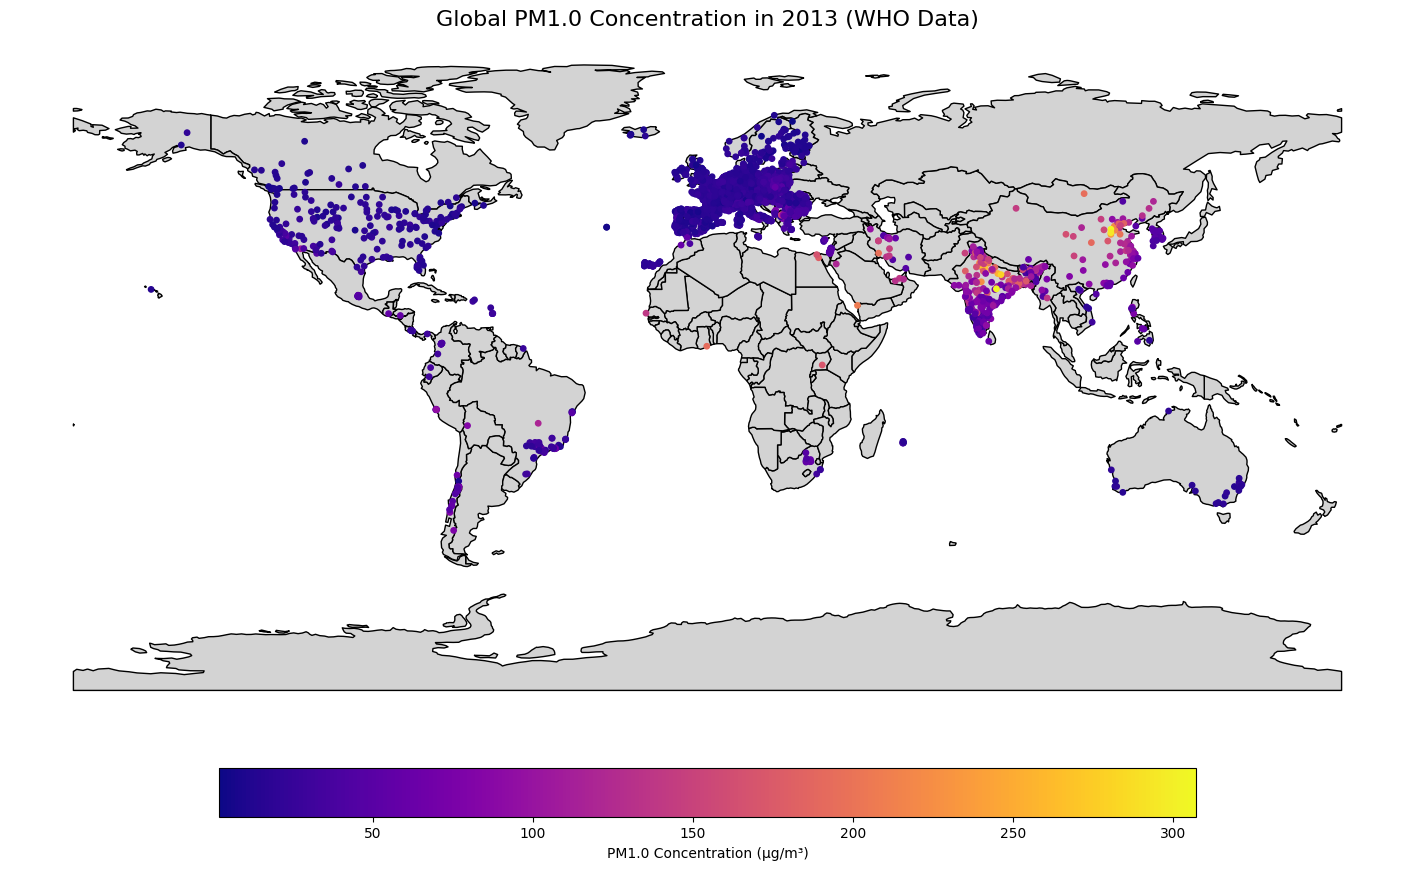

Saved frame for year 2013


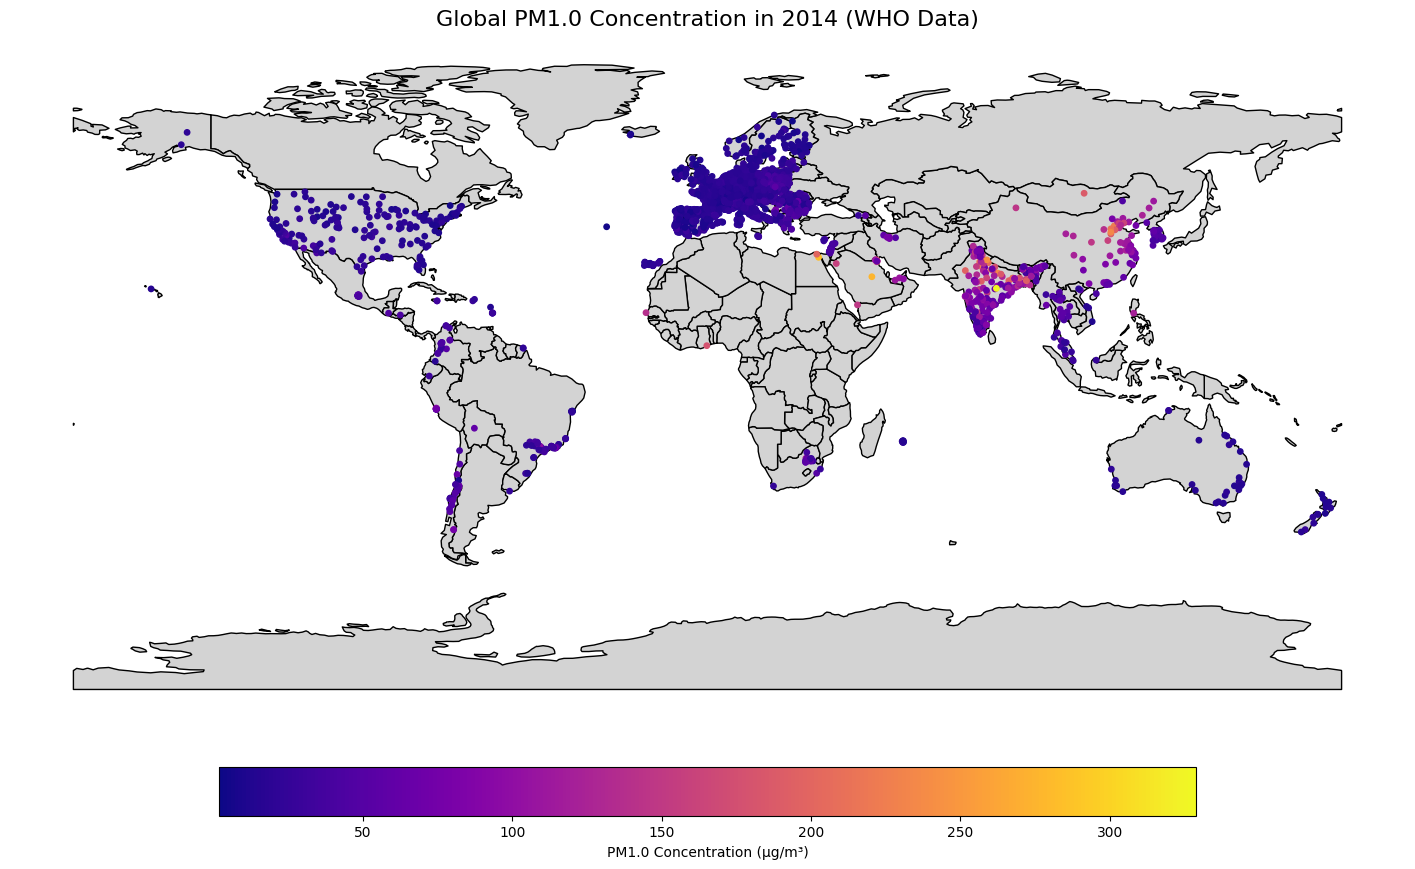

Saved frame for year 2014


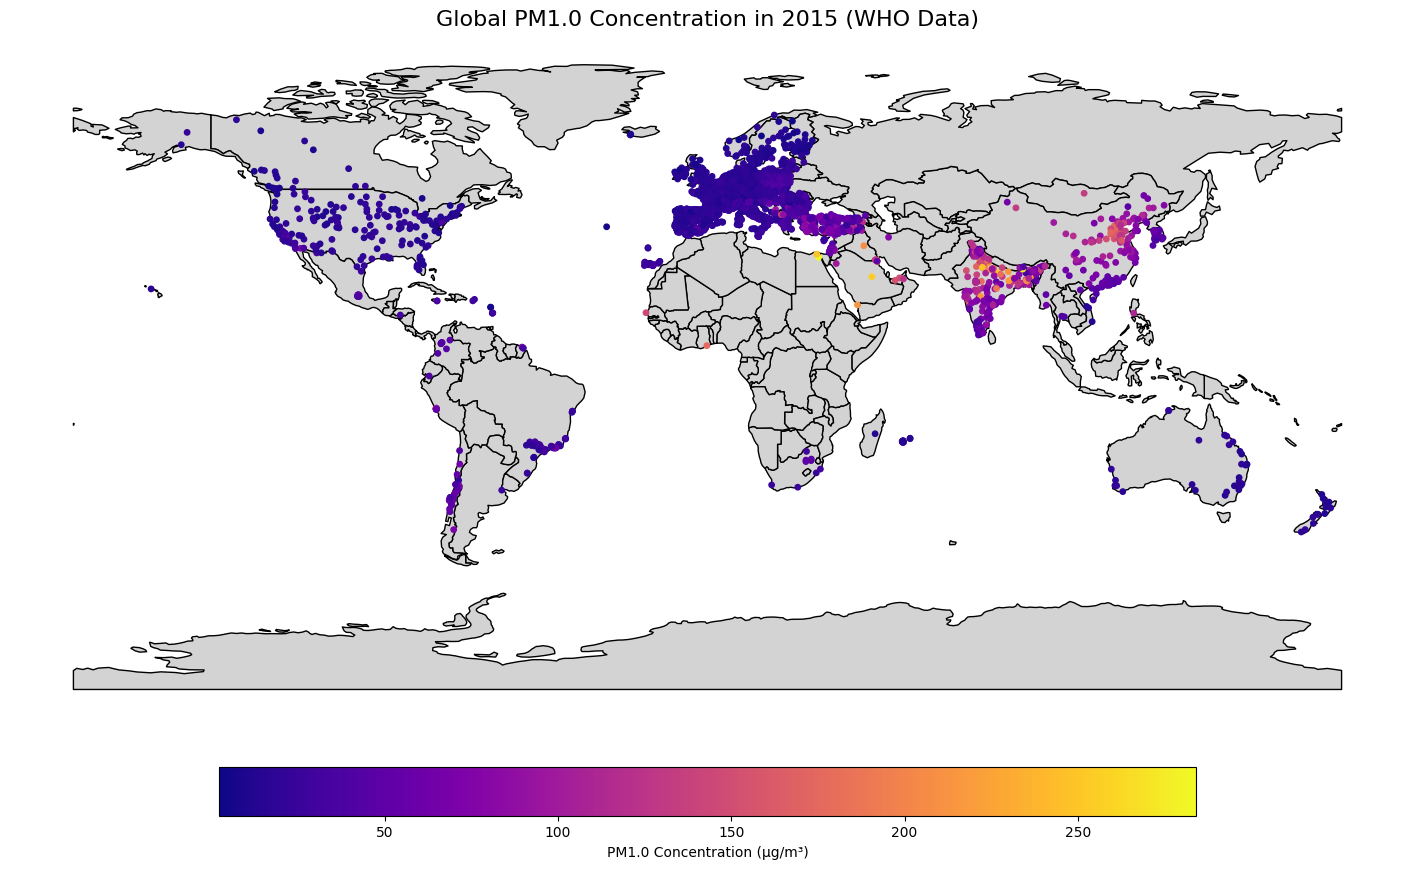

Saved frame for year 2015


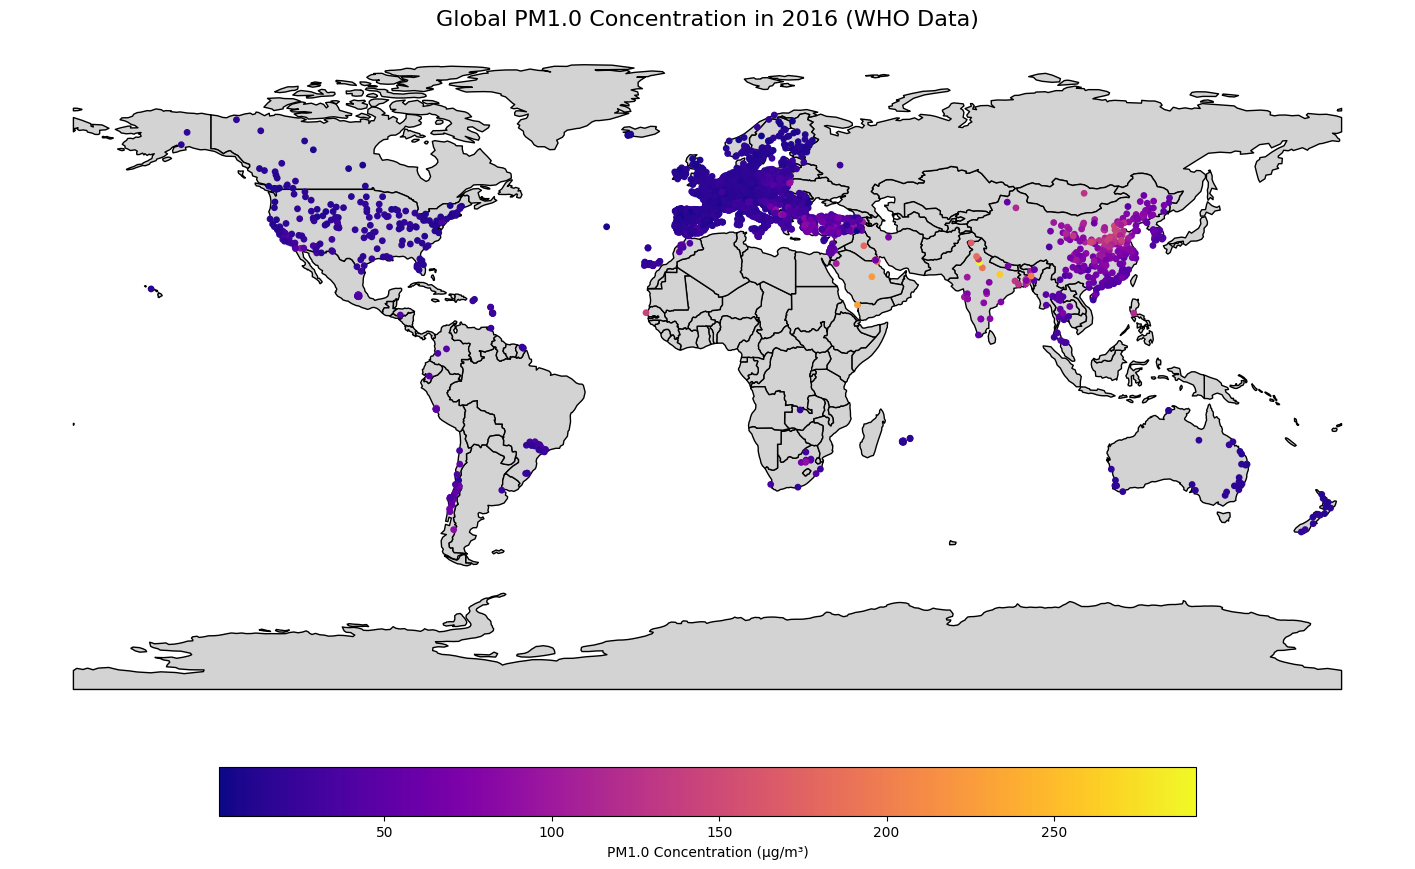

Saved frame for year 2016


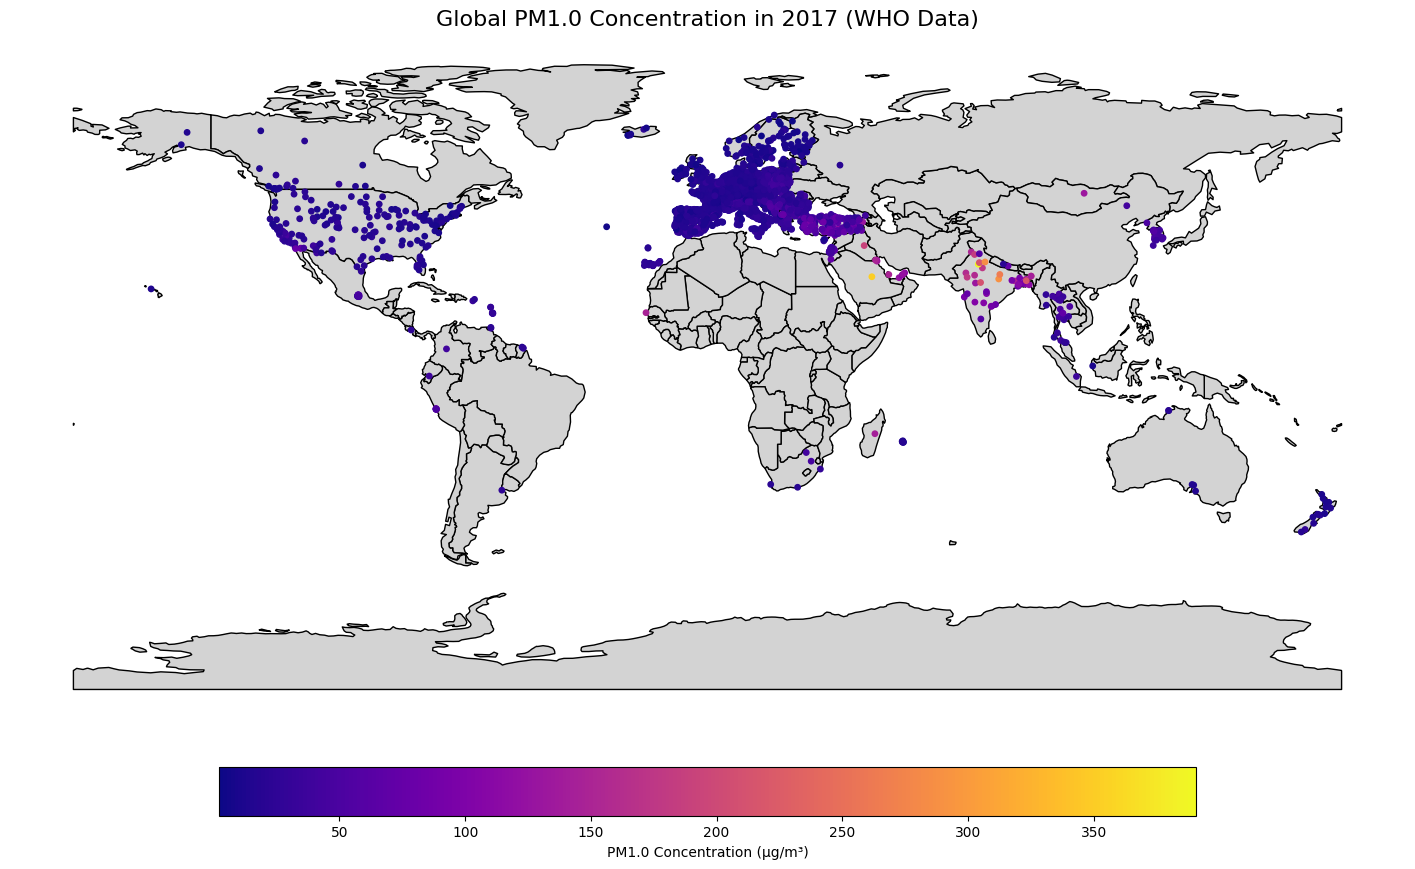

Saved frame for year 2017


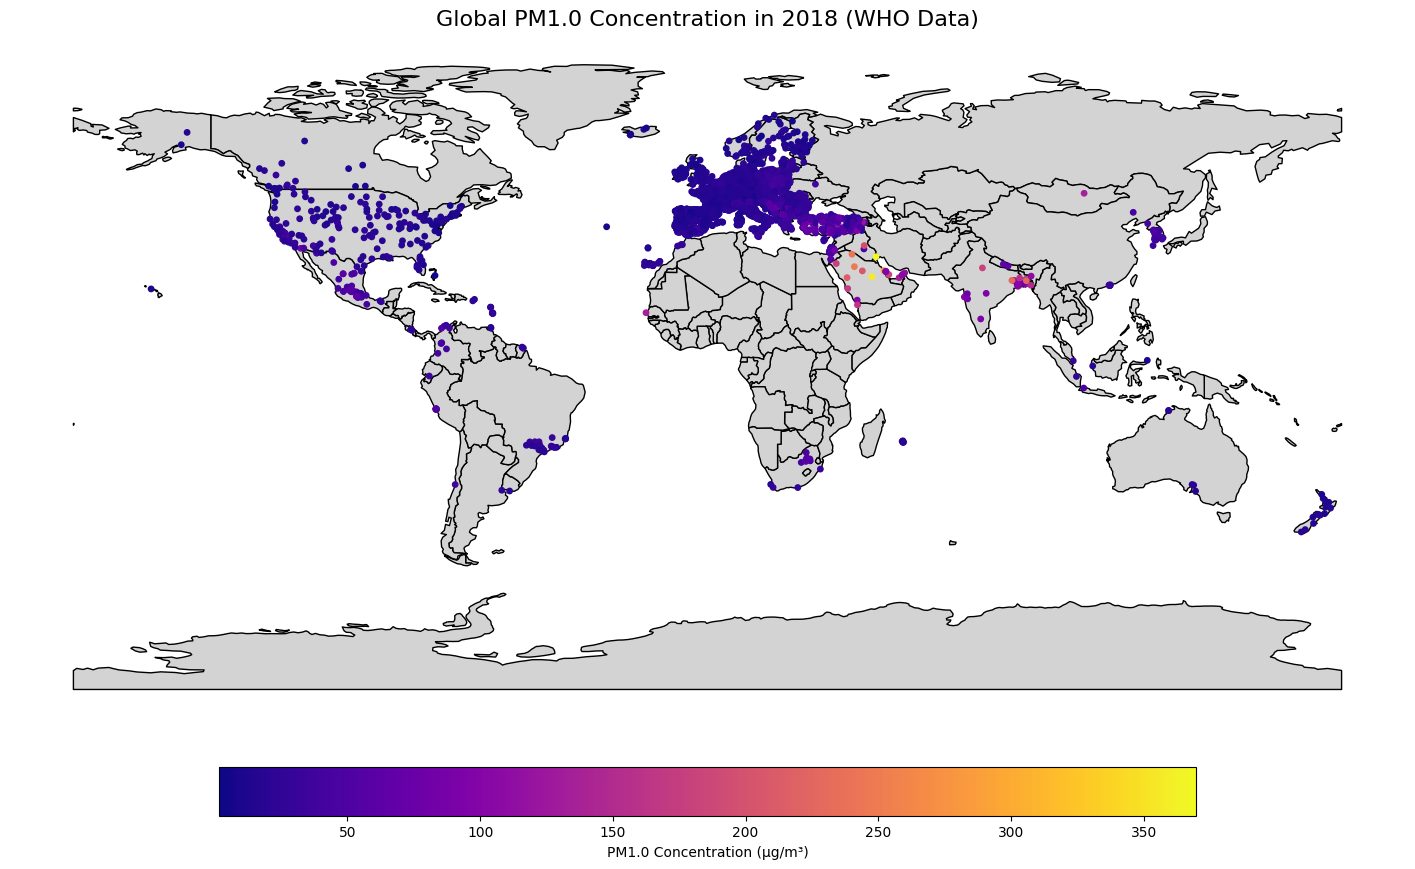

Saved frame for year 2018


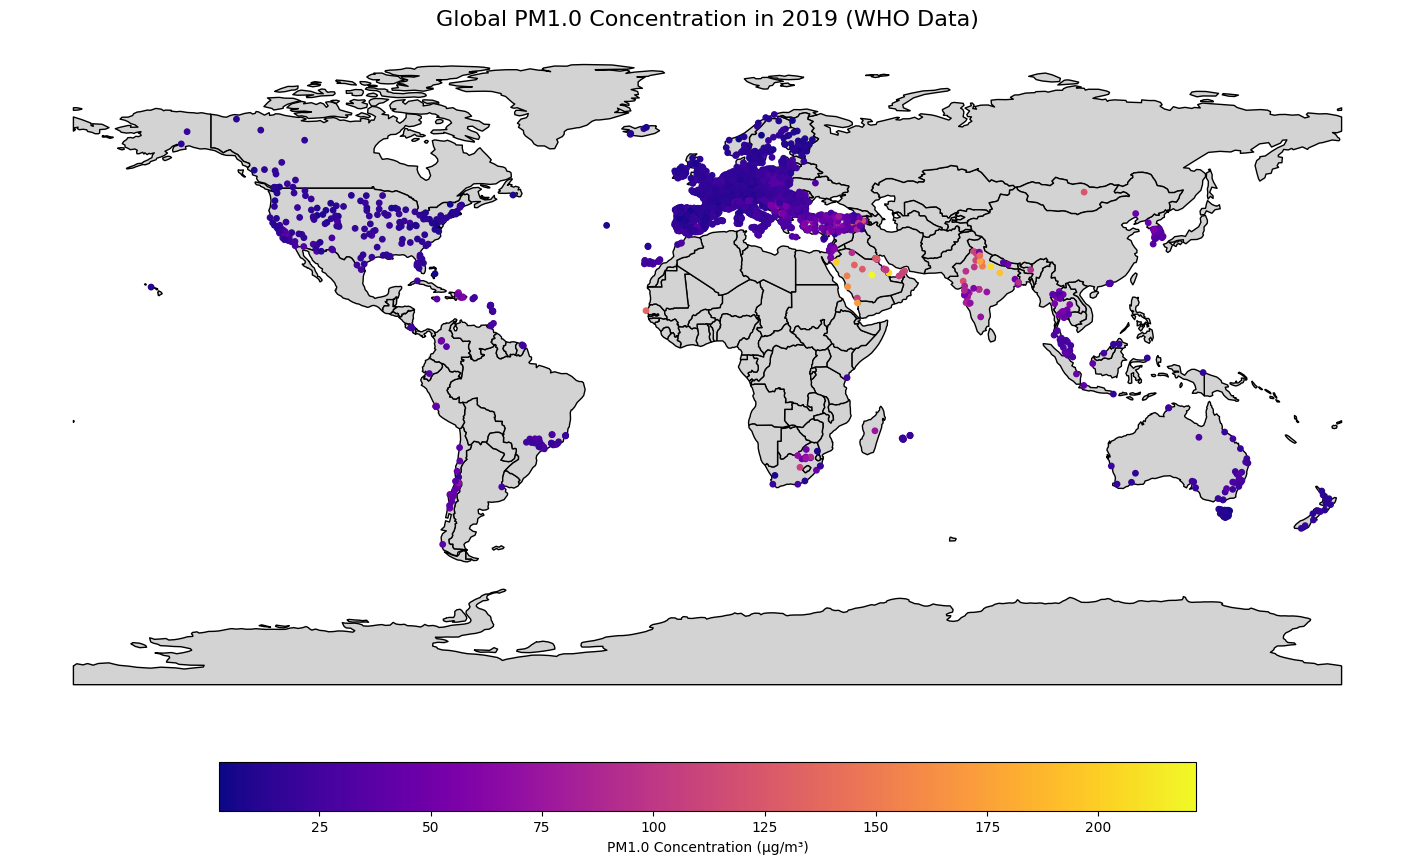

Saved frame for year 2019


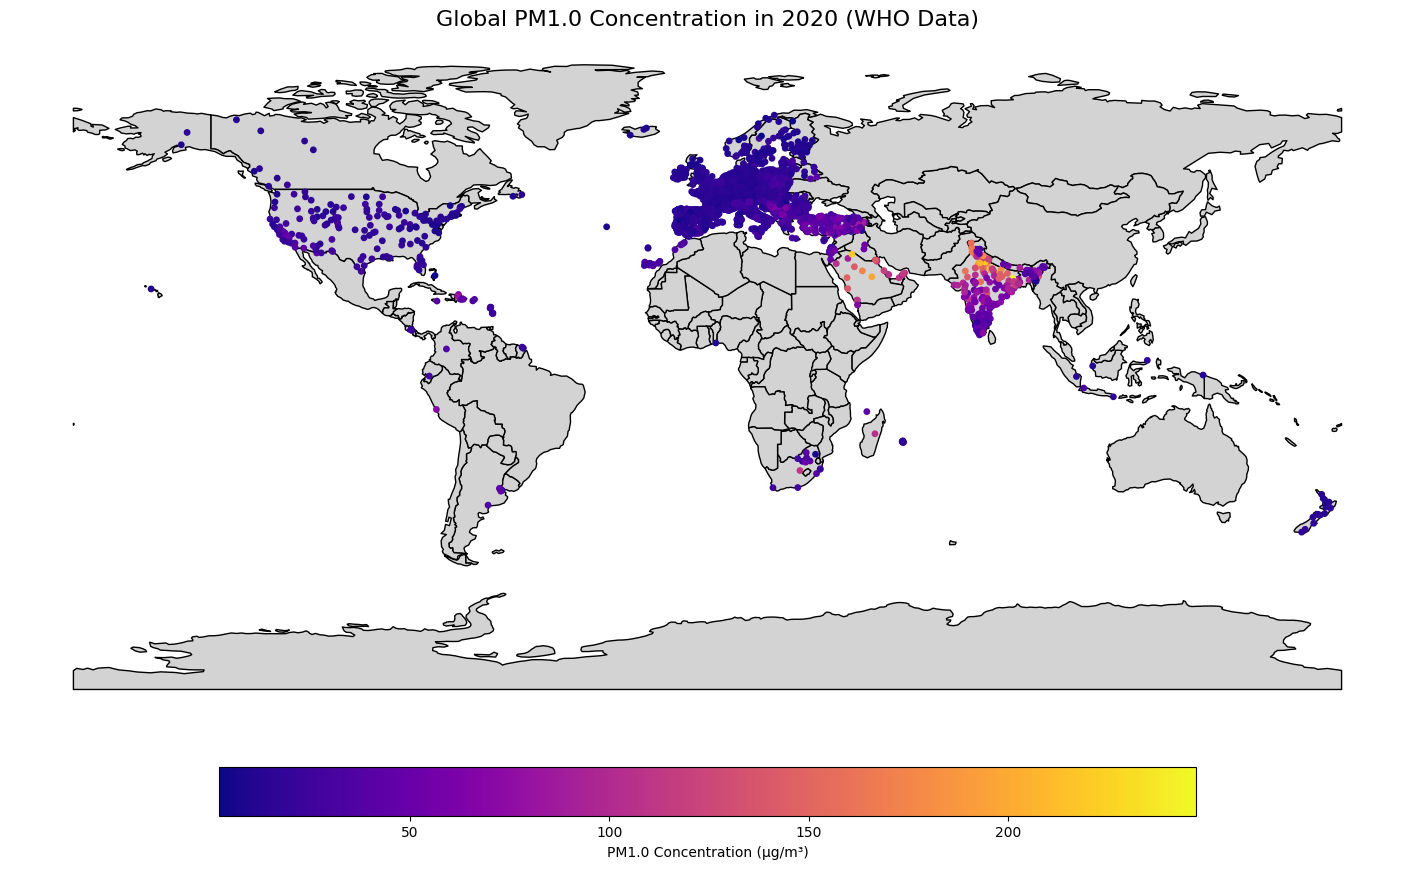

Saved frame for year 2020


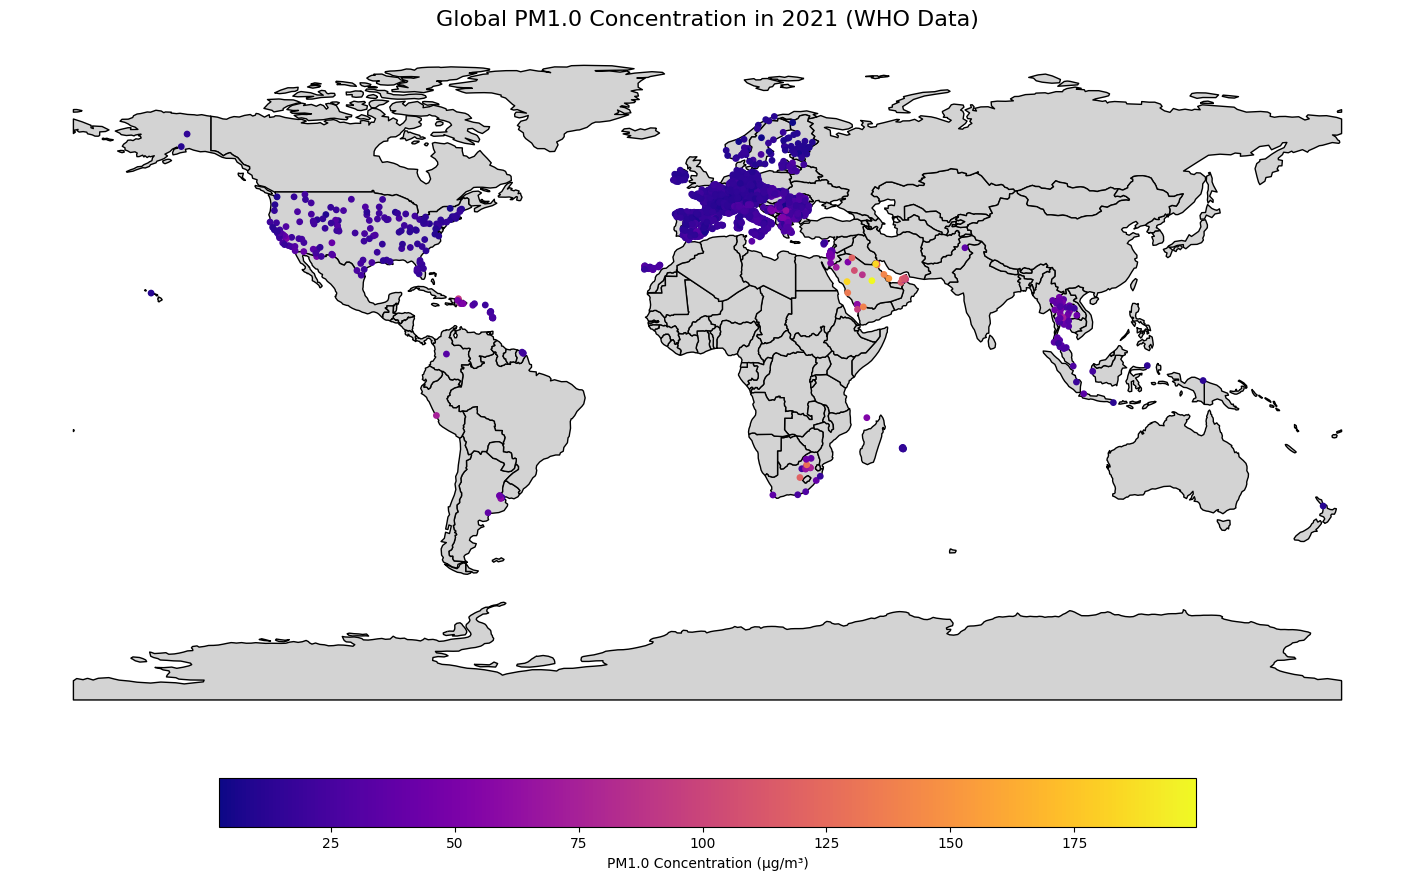

Saved frame for year 2021


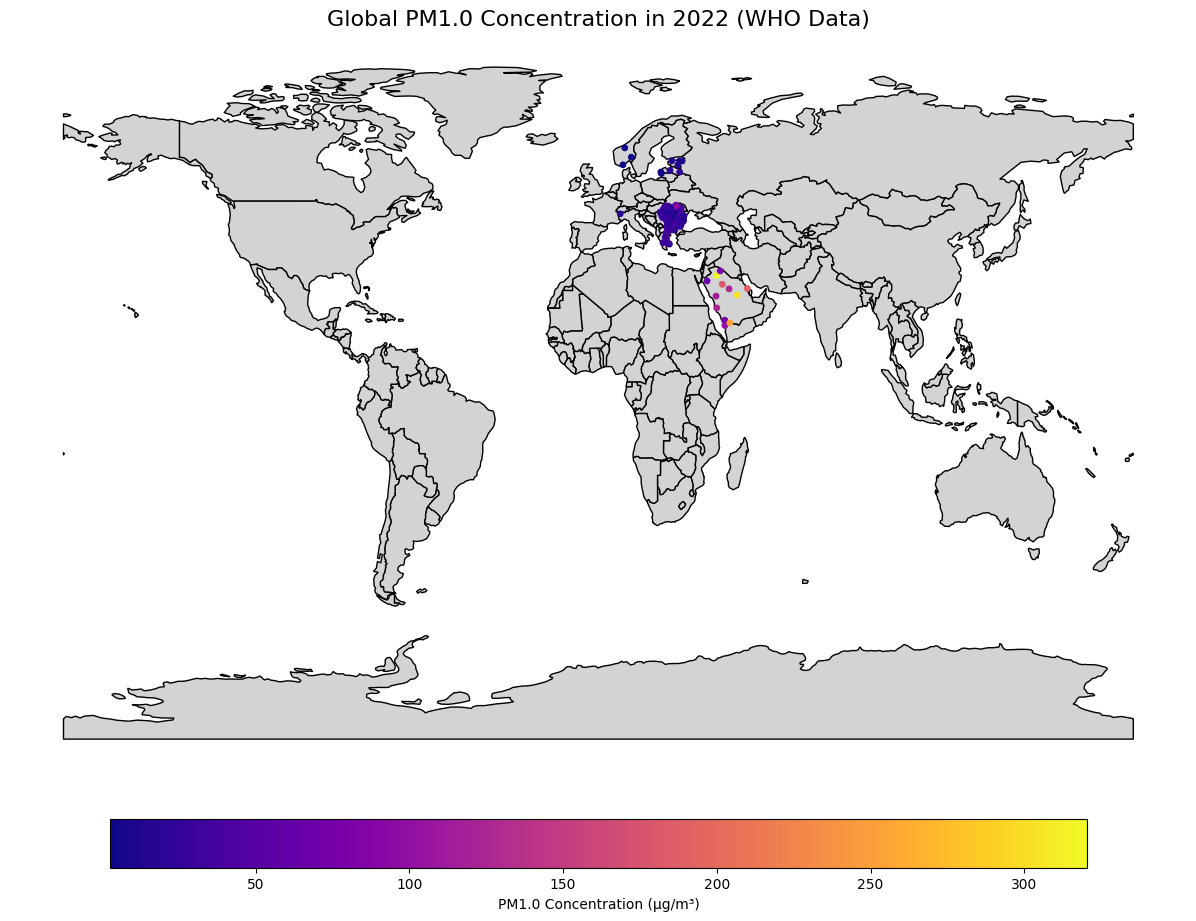

Saved frame for year 2022


In [ ]:
# Get available years from your cleaned GeoDataFrame
available_years = sorted(gdf['year'].unique().tolist())
print(f"Years available in data: {available_years}")
image_paths = []

for year_to_plot in available_years:
              gdf_year = gdf[gdf['year'] == year_to_plot]

              fig, ax = plt.subplots(1, 1, figsize=(18, 12)) # Larger figure size for global map

              # Plot the world map for context
              world = gpd.read_file(world_map_shp_path)
              world.plot(ax=ax, color='lightgrey', edgecolor='black', zorder=0)

              # Plot the AQI data points on top
              # Using 'pm25_conc' for color, 'cmap' for colormap, 's' for marker size
              # 'legend=True' to show the color scale
              gdf_year.plot(column='pm10_concentration',
                            cmap='plasma', # Yellow-Orange-Red colormap (lower is better, higher is red)
                            markersize=15, # Adjust marker size as needed
                            legend=True,
                            legend_kwds={'label': "PM1.0 Concentration (µg/m³)",
                                        'orientation': "horizontal",
                                        'pad': 0.05, # Padding for the legend
                                        'shrink': 0.7}, # Shrink the legend size
                            ax=ax,
                            zorder=1) # Ensure points are above the world map

              ax.set_xlim([-180, 180]) # Longitude range
              ax.set_ylim([-90, 90])   # Latitude range
              ax.set_title(f'Global PM1.0 Concentration in {year_to_plot} (WHO Data)', fontsize=16)
              ax.set_xlabel('Longitude', fontsize=12)
              ax.set_ylabel('Latitude', fontsize=12)
              ax.set_axis_off() # Hide axes for cleaner map

              frame_path = os.path.join(temp_frames_dir, f'global_aqi_pm10_{year_to_plot}.png')
              plt.savefig(frame_path, dpi=150) # Use dpi for resolution
              image_paths.append(frame_path)
              plt.show()
              plt.close(fig) # IMPORTANT: Close the figure to free up memory
              print(f"Saved frame for year {year_to_plot}")

In [33]:
# Sort image paths to ensure correct animation order
image_paths.sort()
image_paths

AttributeError: 'str' object has no attribute 'sort'

In [32]:
if image_paths:
    # Read all images into a list
    images = [imageio.imread(file) for file in image_paths]

    # Create the GIF
    # 'fps' (frames per second) controls the speed of the animation.
    # 2 fps means each frame is shown for 0.5 seconds.
    imageio.mimsave(output_gif_path, images, fps=2)
    print(f"GIF saved successfully to: {output_gif_path}")
else:
    print("No image frames were generated to create the GIF. Check previous steps for errors.")


C:\Users\menak\AppData\Local\Temp\ipykernel_15592\245341930.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(file) for file in image_paths]


ValueError: ImageIO does not generally support reading folders. Limited support may be available via specific plugins. Specify the plugin explicitly using the `plugin` kwarg, e.g. `plugin='DICOM'`